# Sprint 3 Analysis

In [1]:
from arsenic import plotting, stats # useful FE analysis functions
import json
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import seaborn as sns
from openeye import oechem
import numpy as np
from fah_xchem.analysis.constants import KT_KCALMOL # to convert from kT to kcal per mol

In [2]:
# For Sprint 3 we have separate backwards and forwards jsons
# Read them in
with open('../../data/sprint-3/2020-08-20-benzotriazoles-backwards/analysis.json', 'r') as file:
    backwards_data = json.load(file)
with open('../../data/sprint-3/2020-08-20-benzotriazoles-forwards/analysis.json', 'r') as file:
    forwards_data = json.load(file)

In this set, there are two reference ligands:
* `ALP-POS-c59291d4-2` -> `2020-08-20-benzotriazoles-dockscores-x10871.sdf` (https://covid.postera.ai/covid/submissions/c59291d4-9418-42d0-bac0-4b33c16373ba/2)
* `ALP-POS-d2866bdf-1` -> `2020-08-20-benzotriazoles-dockscores-x10876.sdf` (https://covid.postera.ai/covid/submissions/d2866bdf-f3e4-40b3-a1f0-30bc7eb933f4/1)

*Note:* The scaffold has been changed slightly for `ALP-POS-c59291d4-2` (i.e. in `ligands.sdf`)

Checking data for any enantiomers. If there are, we take the better fe value:
(from `@hannahbrucemacdonald`)

In [3]:
results_sets = {}
expanding_stereochemistry = {}

for run in backwards_data['runs']:
    
    protein = run['details']['protein']
    ligand = run['details']['ligand']
    
    if (protein, ligand) not in results_sets:
        results_sets[(protein, ligand)] = {}
    
    title = run['details']['start_title']
    fe = run['analysis']['binding']['delta_f']
    dfe = run['analysis']['binding']['ddelta_f']
    
    if title in results_sets[(protein, ligand)]:
        ## We have another enantiomer
        if fe < results_sets[(protein, ligand)][title][0]:
            results_sets[(protein, ligand)][title] = (fe, dfe) # if it's better, replace it
    else:
        results_sets[(protein, ligand)][title] = (fe, dfe)
    
    if title not in expanding_stereochemistry:
        expanding_stereochemistry[title] = {run['details']['start_smiles']:(fe, dfe)}
    else:
        expanding_stereochemistry[title][run['details']['start_smiles']] = (fe, dfe)

In [4]:
nope = []
for title, values in expanding_stereochemistry.items():
    if len(values) == 1:
        nope.append(title)
        
for title in nope:
    del expanding_stereochemistry[title]
print(f'{len(expanding_stereochemistry)} molecules with enantiomers')

0 molecules with enantiomers


## Forwards vs. Backwards analysis

Here, we will analyse both the forward and backward transformations to measure agreement between calculated $\Delta\Delta$G values. This analysis relies heavily on `networkx` to build graphs of transformations. We will build a total of four grpahs consisting of:

* Forwards only transformations (`forwards`)
* Backwards only transformations (`backwards`)
* Forwards and backwards transformations (`both`)
* Averaged forwards and backwards transformations (`comb`)

#### Run the analysis

In [5]:
import networkx as nx

graphs = {} # a place to store graphs
r = {} # a place to store results (i.e. a dict of graphs to access later)

##################
# Backwards Data #
##################
for d in backwards_data['runs']:
    protein = d['details']['protein']
    ligand = d['details']['ligand']

    direction = 'backwards'  
    if 'start_title' not in d['details']:
        print(d)
        continue
    if 'end_title' not in d['details']:
        print(d)
        continue

    
    # see if a graph exists for the given protein-ligand-direction combination 
    if (protein, ligand, direction) not in graphs:
        graphs[(protein, ligand, direction)] = nx.DiGraph()
        r[(protein, ligand, direction)] = {}  # create a dictionary to keep track of everything (i.e. in the graphs)
        #r[(protein, ligand, direction)]['LIG(A-4000)'] = (0.,0.,0.)
    
    # add "both" direction entry i.e. if we have forwards and backwards
    if (protein, ligand, 'both') not in graphs:
        graphs[(protein, ligand, 'both')] = nx.DiGraph()
        
    graph = graphs[(protein, ligand, direction)]
    
    # if we have both complex and solvent phases, add the data
    if 'complex_phase' in d['analysis'] and 'solvent_phase' in d['analysis']: 

        # get the binding free energies (and variance)
        DDG = d['analysis']['binding']['delta_f']
        dDDG = d['analysis']['binding']['ddelta_f'] # the calculated variance, assuming guassian distribution
        if np.abs(DDG) > 100:
            continue

        # create the edge, with specific keywords
        graph.add_edge(d['details']['start'],
                       d['details']['end'],
                       start_title=d['details']['start_title'],
                       end_title=d['details']['end_title'],
                       calc_DDG=KT_KCALMOL*DDG, 
                       calc_dDDG=KT_KCALMOL*dDDG, 
                    #    calc_DDG_low=KT_KCALMOL*d['analysis']['binding']['ddelta_f'], 
                    #    calc_DDG_high=KT_KCALMOL*d['analysis']['binding']['ddelta_f'],
                       exp_DDG=0.,
                       exp_dDDG=0.1) # experimental variance
        
        # TODO: do we need this below?(commented out)
        
        #print(d['details']['start_title'], r[(protein, ligand, direction)])
#         if d['details']['start_title'] in r[(protein, ligand, direction)]:
#             fe = [-i for i in KT_KCALMOL*(d['analysis']['binding']['delta_f'])]
#             print(fe)
            
#             # 
#             if fe[0] > r[(protein, ligand, direction)][d['details']['start_title']]:
#                 r[(protein, ligand, direction)][d['details']['start_title']] = [-KT_KCALMOL*(d['analysis']['binding']['delta_f'])]
# #                 print(d['start_title'], r[(protein, ligand, direction)][d['start_title']], KT_KCALMOL*(d['binding_fe']))
#         else:
#             r[(protein, ligand, direction)][d['details']['start_title']] = [-KT_KCALMOL*(d['analysis']['binding']['delta_f'])]
#             #print(r[(protein, ligand, direction)][d['details']['start_title']])
        
        # set this direction (backwards) to be negative
        r[(protein, ligand, direction)][d['details']['start_title']] = -KT_KCALMOL*DDG

        # Now add this direction to the "both" graph
        
        graph = graphs[(protein, ligand, 'both')]
        
        graph.add_edge(d['details']['start'],
                       d['details']['end'],
                       start_title=d['details']['start_title'],
                       end_title=d['details']['end_title'],
                       calc_DDG=KT_KCALMOL*DDG,
                       calc_dDDG=KT_KCALMOL*dDDG, 
                    #    calc_DDG_low = KT_KCALMOL*d['analysis']['binding']['ddelta_f'],
                    #    calc_DDG_high=KT_KCALMOL*d['analysis']['binding']['ddelta_f'],
                       exp_DDG=0.,
                       exp_dDDG=0.1
                      )



#################
# Forwards Data #
#################
for d in forwards_data['runs']:
    protein = d['details']['protein']
    ligand = d['details']['ligand']
    direction = 'forwards' 
    
    if 'start_title' not in d['details']:
        print(d)
        continue
    if 'end_title' not in d['details']:
        print(d)
        continue


    # see if a graph exists for the given protein-ligand-direction combination 
    if (protein, ligand, direction) not in graphs:
        graphs[(protein, ligand, direction)] = nx.DiGraph()
        r[(protein, ligand, direction)] = {}
        #r[(protein, ligand, direction)]['LIG(A-4000)'] = (0.,0.,0.)

    if (protein, ligand, 'both') not in graphs:
        graphs[(protein, ligand, 'both')] = nx.DiGraph()
        
    graph = graphs[(protein, ligand, direction)]

    if 'complex_phase' in d['analysis'] and 'solvent_phase' in d['analysis']:  

        DDG = d['analysis']['binding']['delta_f']
        dDDG = d['analysis']['binding']['ddelta_f'] # the calculated variance, assuming guassian distribution
        if np.abs(DDG) > 100:
            continue

        graph.add_edge(d['details']['start'],
                       d['details']['end'],
                       start_title=d['details']['start_title'],
                       end_title=d['details']['end_title'],
                       calc_DDG=KT_KCALMOL*DDG,
                       calc_dDDG=KT_KCALMOL*dDDG,
                       calc_DDG_low=KT_KCALMOL*d['analysis']['binding']['ddelta_f'],  # TODO: this is wrong
                       calc_DDG_high=KT_KCALMOL*d['analysis']['binding']['ddelta_f'], # TODO: this is wrong
                       exp_DDG=0.,
                       exp_dDDG=0.1)

        # set this direction (forwards) to be positive
        r[(protein, ligand, direction)][d['details']['end_title']] = KT_KCALMOL*DDG
 
        graph = graphs[(protein, ligand, 'both')]

        graph.add_edge(d['details']['start'],
                       d['details']['end'],
                       start_title=d['details']['start_title'],
                       end_title=d['details']['end_title'],
                       calc_DDG=KT_KCALMOL*DDG,
                       calc_dDDG=KT_KCALMOL*dDDG,
                    #    calc_DDG_low =KT_KCALMOL*d['analysis']['binding']['ddelta_f'],  # TODO: this is wrong
                    #    calc_DDG_high=KT_KCALMOL*d['analysis']['binding']['ddelta_f'],  # TODO: this is wrong
                       exp_DDG=0.,
                       exp_dDDG=0.1
                      )

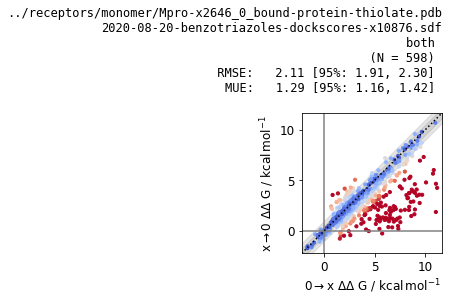

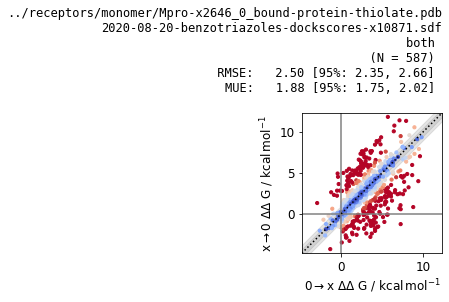

In [9]:
to_delete = []

# make combined graphs that have "both" directions (forwards and backwards), these will contain the average DDG
comb_graphs = [t for t in graphs if 'both' in t]

for t in comb_graphs:
    old_graph = graphs[t]
    graphs[(t[0],t[1],'comb')] = nx.DiGraph()
    r[(t[0],t[1],'comb')] = {}
    new_graph = graphs[(t[0],t[1],'comb')]
    x = []
    y = []
    for edge in old_graph.edges(data=True):
        if edge[0] == 0:
            if old_graph.has_edge(edge[1],edge[0]):
                
                    x.append(-edge[2]['calc_DDG']) # forwards transformation, define as -ve 
                    y.append(old_graph.get_edge_data(edge[1],edge[0])['calc_DDG']) # backwards transformation, define as +ve

                    DDG = 0.5*(-edge[2]['calc_DDG'] + old_graph.get_edge_data(edge[1],edge[0])['calc_DDG'])
                    dDDG = (edge[2]['calc_dDDG']**2 + old_graph.get_edge_data(edge[1],edge[0])['calc_dDDG']**2)**0.5
                    # DDG_low = 0.5*(edge[2]['calc_DDG_low']-old_graph.get_edge_data(edge[1],edge[0])['calc_DDG_low']) # this isn't right 
                    # DDG_high = 0.5*(edge[2]['calc_DDG_high']-old_graph.get_edge_data(edge[1],edge[0])['calc_DDG_high']), # this isn't right

                    new_graph.add_edge(edge[0],edge[1],
                                   start_title=edge[2]['start_title'],
                                   end_title=edge[2]['end_title'],
                                   calc_DDG=DDG,
                                   calc_dDDG=dDDG,
                                   #calc_DDG_low=DDG_low,
                                   #calc_DDG_high=DDG_high,
                                   #calc_dDDG=(edge[2]['calc_dDDG']**2+old_graph.get_edge_data(edge[1],edge[0])['calc_dDDG']**2)**0.5,
                                   exp_DDG=0.,
                                   exp_dDDG=0.1)

                    if edge[1] in r[(t[0],t[1], 'comb')]:
                        print(edge[1])

                    else:
                        #r[(t[0],t[1], 'comb')][edge[1]] = [DDG, DDG_low, DDG_high]
                        r[(t[0],t[1], 'comb')][edge[1]] = [DDG, dDDG]

    if len(x) > 0 :
        plotting._master_plot(
            np.asarray(x), # the forwards transformation
            np.asarray(y), # the backwards transformation
            title=f"{t[0]}\n{t[1]}\n{t[2]}",
            xlabel=r'0$\rightarrow$x',
            ylabel=r'x$\rightarrow$0'
            )

    to_delete.append(t)

# remove the graph ('both') to keep things clean
for d in to_delete:
    del graphs[d]

From a first look we can see that:

* For `10876.sdf` the forwards transformation is more variable in its agreement with backwards, there is a high degree of non-symmetry about `x=y`.
* For `10871.sdf` the distribution is more symmetric about `x=y` 

Attempt to filter results within a cutoff (X kcal mol$^{-1}$) difference between `forwards` and `backwards` sets. This will allow us to investigate agreement between the two directions.

First, we construct our graphs again (can probably clean this up later):

In [12]:
import networkx as nx

graphs = {}
r = {}

##################
# Backwards Data #
##################
for d in backwards_data['runs']:
    protein = d['details']['protein']
    ligand = d['details']['ligand']

    direction = 'backwards'  
    if 'start_title' not in d['details']:
        print(d)
        continue
    if 'end_title' not in d['details']:
        print(d)
        continue

    
    # see if a graph exists for the given protein-ligand-direction combination 
    if (protein, ligand, direction) not in graphs:
        graphs[(protein, ligand, direction)] = nx.DiGraph()
        r[(protein, ligand, direction)] = {}  # create a dictionary to keep track of everything (i.e. in the graph)
        #r[(protein, ligand, direction)]['LIG(A-4000)'] = (0.,0.,0.)  # TODO: change this
    
    # add "both" direction entry i.e. if we have forwards and backwards
    if (protein, ligand, 'both') not in graphs:
        graphs[(protein, ligand, 'both')] = nx.DiGraph()
        
    graph = graphs[(protein, ligand, direction)]
    
    # if we have both complex and solvent phases, add the data
    if 'complex_phase' in d['analysis'] and 'solvent_phase' in d['analysis']: 

        # get the binding free energies (and variance)
        DDG = d['analysis']['binding']['delta_f']
        dDDG = d['analysis']['binding']['ddelta_f']#  the calculated variance, assuming guassian distribution
        if np.abs(DDG) > 100:
            continue

        # create the edge, with specific keywords
        graph.add_edge(d['details']['start'],
                       d['details']['end'],
                       start_title=d['details']['start_title'],
                       end_title=d['details']['end_title'],
                       calc_DDG=KT_KCALMOL*DDG,
                       calc_dDDG=KT_KCALMOL*dDDG,
                       #calc_DDG_low=KT_KCALMOL*d['analysis']['binding']['ddelta_f'],  # TODO: this is wrong
                       #calc_DDG_high=KT_KCALMOL*d['analysis']['binding']['ddelta_f'], # TODO: this is wrong
                       exp_DDG=0.,
                       exp_dDDG=0.1)
        
        # TODO: do we need this below?(commented out)
        
        #print(d['details']['start_title'], r[(protein, ligand, direction)])
#         if d['details']['start_title'] in r[(protein, ligand, direction)]:
#             fe = [-i for i in KT_KCALMOL*(d['analysis']['binding']['delta_f'])]
#             print(fe)
            
#             # 
#             if fe[0] > r[(protein, ligand, direction)][d['details']['start_title']]:
#                 r[(protein, ligand, direction)][d['details']['start_title']] = [-KT_KCALMOL*(d['analysis']['binding']['delta_f'])]
# #                 print(d['start_title'], r[(protein, ligand, direction)][d['start_title']], KT_KCALMOL*(d['binding_fe']))
#         else:
#             r[(protein, ligand, direction)][d['details']['start_title']] = [-KT_KCALMOL*(d['analysis']['binding']['delta_f'])]
#             #print(r[(protein, ligand, direction)][d['details']['start_title']])
        
        # set this direction (backwards) to be negative
        r[(protein, ligand, direction)][d['details']['start_title']] = [-KT_KCALMOL*DDG]
        
        graph = graphs[(protein, ligand, 'both')]
        
        graph.add_edge(d['details']['start'],
                       d['details']['end'],
                       start_title=d['details']['start_title'],
                       end_title=d['details']['end_title'],
                       calc_DDG=KT_KCALMOL*DDG,
                       calc_dDDG=KT_KCALMOL*dDDG,
                    #    calc_DDG_low = KT_KCALMOL*d['analysis']['binding']['ddelta_f'],  # TODO: this is wrong
                    #    calc_DDG_high=KT_KCALMOL*d['analysis']['binding']['ddelta_f'],  # TODO: this is wrong
                       exp_DDG=0.,
                       exp_dDDG=0.1
                      )



#################
# Forwards Data #
#################
for d in forwards_data['runs']:
    protein = d['details']['protein']
    ligand = d['details']['ligand']
    direction = 'forwards' 
    
    if 'start_title' not in d['details']:
        print(d)
        continue
    if 'end_title' not in d['details']:
        print(d)
        continue


    # see if a graph exists for the given protein-ligand-direction combination 
    if (protein, ligand, direction) not in graphs:
        graphs[(protein, ligand, direction)] = nx.DiGraph()
        r[(protein, ligand, direction)] = {}
        r[(protein, ligand, direction)]['LIG(A-4000)'] = (0.,0.,0.)  # TODO: change this

    if (protein, ligand, 'both') not in graphs:
        graphs[(protein, ligand, 'both')] = nx.DiGraph()
        
    graph = graphs[(protein, ligand, direction)]

    if 'complex_phase' in d['analysis'] and 'solvent_phase' in d['analysis']:  

        DDG = d['analysis']['binding']['delta_f']
        dDDG = d['analysis']['binding']['ddelta_f'] # the calculated variance, assuming guassian distribution
        if np.abs(DDG) > 100:
            continue

        graph.add_edge(d['details']['start'],
                       d['details']['end'],
                       start_title=d['details']['start_title'],
                       end_title=d['details']['end_title'],
                       calc_DDG=KT_KCALMOL*DDG,
                       calc_dDDG=KT_KCALMOL*dDDG,
                    #    calc_DDG_low=KT_KCALMOL*d['analysis']['binding']['ddelta_f'],  # TODO: this is wrong
                    #    calc_DDG_high=KT_KCALMOL*d['analysis']['binding']['ddelta_f'], # TODO: this is wrong
                       exp_DDG=0.,
                       exp_dDDG=0.1)

        # set this direction (forwards) to be positive
        r[(protein, ligand, direction)][d['details']['end_title']] = KT_KCALMOL*DDG
 
        graph = graphs[(protein, ligand, 'both')]

        graph.add_edge(d['details']['start'],
                       d['details']['end'],
                       start_title=d['details']['start_title'],
                       end_title=d['details']['end_title'],
                       calc_DDG=KT_KCALMOL*DDG,
                       calc_dDDG=KT_KCALMOL*dDDG,
                    #    calc_DDG_low =KT_KCALMOL*d['analysis']['binding']['ddelta_f'],  # TODO: this is wrong
                    #    calc_DDG_high=KT_KCALMOL*d['analysis']['binding']['ddelta_f'],  # TODO: this is wrong
                       exp_DDG=0.,
                       exp_dDDG=0.1
                      )

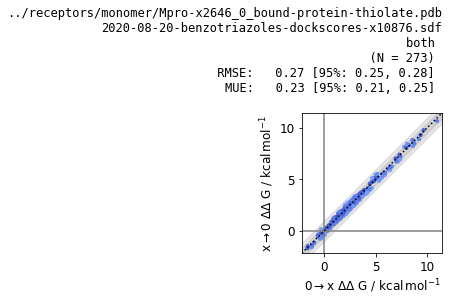

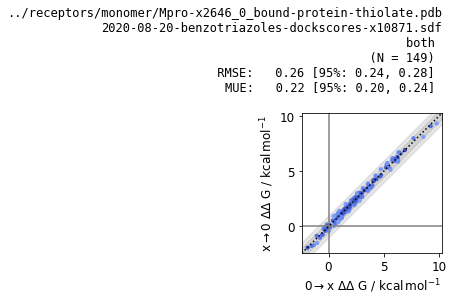

In [16]:
# to_delete = []

# make combined graphs that have "both" directions (forwards and backwards)
comb_graphs = [t for t in graphs if 'both' in t]

for t in comb_graphs:
    old_graph = graphs[t]
    graphs[(t[0],t[1],'comb')] = nx.DiGraph()
    r[(t[0],t[1],'comb')] = {}
    new_graph = graphs[(t[0],t[1],'comb')] # make new graph with average of fwds and bkwds
    x = []
    y = []
    
    # Go through each edge and if there is an edge with 0 -> 1 and 1 -> 0
    # then get information and average fwds and bkwds.
    for edge in old_graph.edges(data=True):
        if edge[0] == 0:
            if old_graph.has_edge(edge[1],edge[0]):

                    # only store / make the entry if the difference between backwards and forwards is within 0.5 kcal / mol
                    if np.abs(-edge[2]['calc_DDG'] - (old_graph.get_edge_data(edge[1],edge[0])['calc_DDG'])) < 0.5:

                       # print(edge)
                
                        x.append(-edge[2]['calc_DDG']) # forwards transformation, define as -ve 
                        y.append(old_graph.get_edge_data(edge[1],edge[0])['calc_DDG']) # backwards transformation, define as +ve 

                        DDG = 0.5*(-edge[2]['calc_DDG'] + old_graph.get_edge_data(edge[1],edge[0])['calc_DDG'])
                        dDDG = (edge[2]['calc_dDDG']**2 + old_graph.get_edge_data(edge[1],edge[0])['calc_dDDG']**2)**0.5
                        # DDG_low = 0.5*(edge[2]['calc_DDG_low']-old_graph.get_edge_data(edge[1],edge[0])['calc_DDG_low']) # this isn't right 
                        # DDG_high = 0.5*(edge[2]['calc_DDG_high']-old_graph.get_edge_data(edge[1],edge[0])['calc_DDG_high']), # this isn't right

                        new_graph.add_edge(edge[0],edge[1],
                                       start_title=edge[2]['start_title'],
                                       end_title=edge[2]['end_title'],
                                       calc_DDG=DDG,
                                    #    calc_DDG_low=DDG_low,
                                    #    calc_DDG_high=DDG_high,
                                       calc_dDDG=(edge[2]['calc_dDDG']**2+old_graph.get_edge_data(edge[1],edge[0])['calc_dDDG']**2)**0.5,
                                       exp_DDG=0.,exp_dDDG=0.1)

                        if edge[1] in r[(t[0],t[1], 'comb')]:
                            print(edge[1])

                        # else:
                        #     r[(t[0],t[1], 'comb')][edge[1]] = [DDG,
                        #                                        DDG_low,
                        #                                        DDG_high,
                        #                                        old_graph.get_edge_data(edge[1],edge[0])['start_title']]
                        else:
                            r[(t[0],t[1], 'comb')][edge[1]] = [
                                DDG,
                                dDDG,
                                # DDG_low,
                                # DDG_high,
                                edge[2]['end_title']
                                ]

    if len(x) > 0 :
        plotting._master_plot(np.asarray(x), np.asarray(y),title=f"{t[0]}\n{t[1]}\n{t[2]}", xlabel=r'0$\rightarrow$x', ylabel=r'x$\rightarrow$0')
    to_delete.append(t)

# for d in to_delete:
#     del graphs[d]

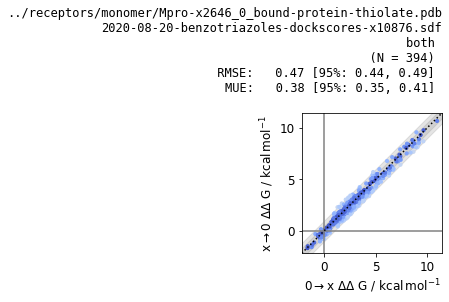

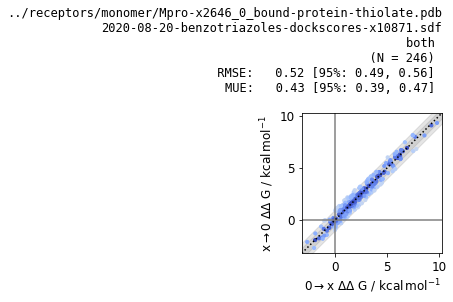

In [14]:
# to_delete = []

# make combined graphs that have "both" directions (forwards and backwards)
comb_graphs = [t for t in graphs if 'both' in t]

for t in comb_graphs:
    old_graph = graphs[t]
    graphs[(t[0],t[1],'comb')] = nx.DiGraph()
    r[(t[0],t[1],'comb')] = {}
    new_graph = graphs[(t[0],t[1],'comb')] # make new graph with average of fwds and bkwds
    x = []
    y = []
    
    # Go through each edge and if there is an edge with 0 -> 1 and 1 -> 0
    # then get information and average fwds and bkwds.
    for edge in old_graph.edges(data=True):
        if edge[0] == 0:
            if old_graph.has_edge(edge[1],edge[0]):

                    # only store / make the entry if the difference between backwards and forwards is within 1 kcal / mol
                    if np.abs(-edge[2]['calc_DDG'] - (old_graph.get_edge_data(edge[1],edge[0])['calc_DDG'])) < 1:
                
                        x.append(-edge[2]['calc_DDG']) # forwards transformation, define as -ve 
                        y.append(old_graph.get_edge_data(edge[1],edge[0])['calc_DDG']) # backwards transformation, define as +ve 

                        DDG = 0.5*(-edge[2]['calc_DDG'] + old_graph.get_edge_data(edge[1],edge[0])['calc_DDG'])
                        dDDG = (edge[2]['calc_dDDG']**2 + old_graph.get_edge_data(edge[1],edge[0])['calc_dDDG']**2)**0.5
                        # DDG_low = 0.5*(edge[2]['calc_DDG_low']-old_graph.get_edge_data(edge[1],edge[0])['calc_DDG_low']) # this isn't right 
                        # DDG_high = 0.5*(edge[2]['calc_DDG_high']-old_graph.get_edge_data(edge[1],edge[0])['calc_DDG_high']), # this isn't right

                        new_graph.add_edge(edge[0],edge[1],
                                       start_title=edge[2]['start_title'],
                                       end_title=edge[2]['end_title'],
                                       calc_DDG=DDG,
                                    #    calc_DDG_low=DDG_low,
                                    #    calc_DDG_high=DDG_high,
                                       calc_dDDG=(edge[2]['calc_dDDG']**2+old_graph.get_edge_data(edge[1],edge[0])['calc_dDDG']**2)**0.5,
                                       exp_DDG=0.,
                                       exp_dDDG=0.1)

                        if edge[1] in r[(t[0],t[1], 'comb')]:
                            print(edge[1])

                        # else:
                        #     r[(t[0],t[1], 'comb')][edge[1]] = [DDG,
                        #                                        DDG_low,
                        #                                        DDG_high,
                        #                                        old_graph.get_edge_data(edge[1],edge[0])['start_title']]
                        else:
                            r[(t[0],t[1], 'comb')][edge[1]] = [
                                DDG,
                                dDDG,
                                # DDG_low,
                                # DDG_high,
                                edge[2]['end_title']
                                ]

    if len(x) > 0 :
        plotting._master_plot(np.asarray(x), np.asarray(y),title=f"{t[0]}\n{t[1]}\n{t[2]}", xlabel=r'0$\rightarrow$x', ylabel=r'x$\rightarrow$0')
    to_delete.append(t)

# for d in to_delete:
#     del graphs[d]

In [33]:
for ligand in r[('../receptors/monomer/Mpro-x2646_0_bound-protein-thiolate.pdb', 
                 '2020-08-20-benzotriazoles-dockscores-x10876.sdf', 'comb')].values():
                 if ligand[0] < -1:
                     print(f"title: {ligand[2]}, DGG: {ligand[0]}, dDGG: {ligand[1]}")

title: BENZO_338_1, DGG: -1.4074691691784746, dDGG: 0.09471920450572505
title: BENZO_350_1, DGG: -1.6576990375304343, dDGG: 0.11423712034151795
title: BENZO_346_1, DGG: -1.0627941810092172, dDGG: 0.12690182566163222
title: BENZO_354_1, DGG: -1.557875217034649, dDGG: 0.11491395275763006
title: BENZO_362_1, DGG: -1.2551539188034657, dDGG: 0.12907785954461798


In [35]:
for ligand in r[('../receptors/monomer/Mpro-x2646_0_bound-protein-thiolate.pdb', 
                 '2020-08-20-benzotriazoles-dockscores-x10871.sdf', 'comb')].values():
                 if ligand[0] < -1:
                     print(f"title: {ligand[2]}, DGG: {ligand[0]}, dDGG: {ligand[1]}")

title: BENZO_24_1, DGG: -1.511330110848411, dDGG: 0.12431831886207442
title: BENZO_338_1, DGG: -1.6481645209437978, dDGG: 0.14351145932660037
title: BENZO_344_1, DGG: -1.268551037623341, dDGG: 0.11606943386776676
title: BENZO_354_1, DGG: -1.9139776188452657, dDGG: 0.13572512439509427


In [39]:
r.keys()

dict_keys([('../receptors/monomer/Mpro-x2646_0_bound-protein-thiolate.pdb', '2020-08-20-benzotriazoles-dockscores-x10876.sdf', 'backwards'), ('../receptors/monomer/Mpro-x2646_0_bound-protein-thiolate.pdb', '2020-08-20-benzotriazoles-dockscores-x10871.sdf', 'backwards'), ('../receptors/monomer/Mpro-x2646_0_bound-protein-thiolate.pdb', '2020-08-20-benzotriazoles-dockscores-x10876.sdf', 'forwards'), ('../receptors/monomer/Mpro-x2646_0_bound-protein-thiolate.pdb', '2020-08-20-benzotriazoles-dockscores-x10871.sdf', 'forwards'), ('../receptors/monomer/Mpro-x2646_0_bound-protein-thiolate.pdb', '2020-08-20-benzotriazoles-dockscores-x10876.sdf', 'comb'), ('../receptors/monomer/Mpro-x2646_0_bound-protein-thiolate.pdb', '2020-08-20-benzotriazoles-dockscores-x10871.sdf', 'comb')])

In [30]:
# for edge in new_graph.edges(data=True):
#     # print(edge)
#     if edge[2]['calc_DDG'] < -1:
#         print(edge[2]['end_title'])

In [96]:
residuals = {}
for p in r.keys():
    if p[2] == 'comb': # not anything to do with the key name, just so we have two
        protein = p[0]
        ligand = p[1]
        residuals[protein, ligand] = {'complex':[],'solvent':[],'complex0':[],'solvent0':[],'complex1':[],'solvent1':[]}

In [97]:
for run_b in backwards_data['runs']:
    for run_f in forwards_data['runs']:

        if run_b['details']['protein'] == run_f['details']['protein']:

            protein = run_b['details']['protein']

            if run_b['details']['ligand'] == run_f['details']['ligand']:

                ligand = run_b['details']['ligand']

                if run_b['details']['start_title'] == run_f['details']['end_title']:

                    # get the complex FEs for the backwards (run_b) and forwards (run_f) transformations
                    # from this use np.abs to calculate the residual

                    residuals[protein, ligand]['complex'].append(
                        np.abs((run_b['analysis']['complex_phase']['free_energy']['delta_f'] + run_f['analysis']['complex_phase']['free_energy']['delta_f']) * KT_KCALMOL)
                        )
                    
                    # get the solvent FEs for the backwards (run_b) and forwards (run_f) transformations
                    # from this use np.abs to calculate the residual

                    residuals[protein, ligand]['solvent'].append(
                        -np.abs((run_b['analysis']['solvent_phase']['free_energy']['delta_f'] + run_f['analysis']['solvent_phase']['free_energy']['delta_f']) * KT_KCALMOL)
                        )

                    # add GEN FEs too?

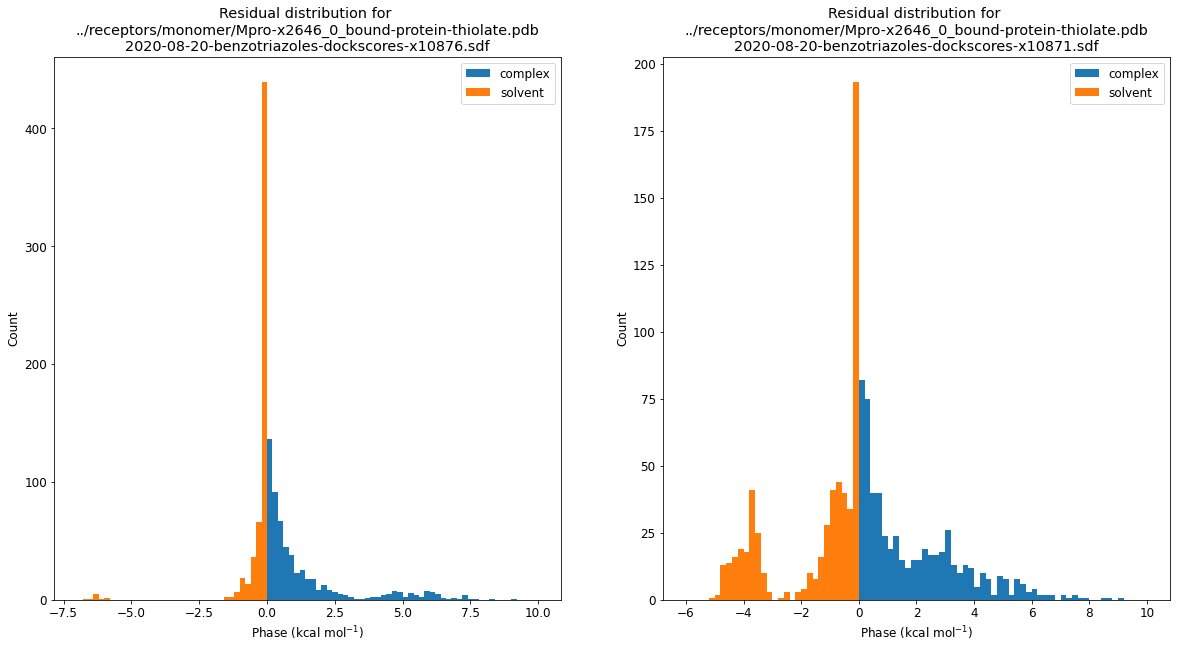

In [127]:
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(20,10))

for i, key in enumerate(residuals):

    minimum = np.floor(min(residuals[key]['solvent']))
    maximum = np.ceil(max(residuals[key]['complex']))
    bins = np.linspace(minimum,maximum,int(5*(maximum-minimum)+1))

    axes[i].hist(residuals[key]['complex'], bins=bins, label="complex")
    axes[i].hist(residuals[key]['solvent'], bins=bins, label="solvent")
    axes[i].legend()
    axes[i].set_xlabel(r"Phase (kcal mol$^{-1}$)") 
    axes[i].set_ylabel("Count") 
    axes[i].set_title(f"Residual distribution for \n{key[0]}\n{key[1]}")

Looking at the "Top 20" ligands (i.e. most negative $\Delta$G values) from https://fah-ws3.s3.amazonaws.com/covid-moonshot/sprints/sprint-3/2020-08-20-benzotriazoles-backwards/index.html

* this is probably a bad way to analyse this
* it would be better to filter first (as attempted above)

In [57]:
top_ligands = [
    "BENZO_8_1",
    "BENZO_13_1",
    "BENZO_46_1",
    "BENZO_345_1",
    "BENZO_98_1",
    "BENZO_184_1",
    "BENZO_70_1",
    "BENZO_350_1",
    "BENZO_179_1",
    "BENZO_183_1",
    "BENZO_180_2",
    "BENZO_248_2",
    "BENZO_266_1",
    "BENZO_187_1",
    "BENZO_27_1",
    "BENZO_264_2",
    "BENZO_26_1",
    "BENZO_3_1",
    "BENZO_94_1",
    "BENZO_354_1",
]

# top_forwards_run_ids = [
#     1464,
#     1469,
#     1753,
#     1480,
#     1463,
#     1458,
#     1478,
#     1483,
#     1476,
#     2151,
#     1475,
#     1460,
#     1477,
#     2155,
#     1470,
#     2148,
#     1967,
#     1785,
#     1465,
#     2140,
    
# ]

# top_ligands_forwards = []

# for d in forwards_data['runs']:
#     #print(d['details'])
#     if d['details']['JOBID'] in top_forwards_run_ids:
#         top_ligands_forwards.append(d['details']['end_title'])
    
# top_ligands2 = set(top_ligands_forwards)

In [12]:
graphs = {}
r = {}

##################
# Backwards Data #
##################
for d in backwards_data['runs']:
    if d['details']['start_title'] in top_ligands:  # only focussing on the top ligands (backwards)

        protein = d['details']['protein']
        ligand = d['details']['ligand']

        direction = 'backwards'  
        if 'start_title' not in d['details']:
            print(d)
            continue
        if 'end_title' not in d['details']:
            print(d)
            continue


        # see if a graph exists for the given protein-ligand-direction combination 
        if (protein, ligand, direction) not in graphs:
            graphs[(protein, ligand, direction)] = nx.DiGraph()
            r[(protein, ligand, direction)] = {}  # create a dictionary to keep track of everything (i.e. in the graph)
            #r[(protein, ligand, direction)]['LIG(A-4000)'] = (0.,0.,0.)  # TODO: change this

        # add "both" direction entry i.e. if we have forwards and backwards
        if (protein, ligand, 'both') not in graphs:
            graphs[(protein, ligand, 'both')] = nx.DiGraph()

        graph = graphs[(protein, ligand, direction)]

        # if we have both complex and solvent phases, add the data
        if 'complex_phase' in d['analysis'] and 'solvent_phase' in d['analysis']: 

            # get the binding free energies (and standard dev)
            DDG = d['analysis']['binding']['delta_f']#[0] 
            dDDG = d['analysis']['binding']['ddelta_f']
            if np.abs(DDG) > 100:
                continue

            # create the edge, with specific keywords
            graph.add_edge(d['details']['start'],
                           d['details']['end'],
                           start_title=d['details']['start_title'],
                           end_title=d['details']['end_title'],
                           calc_DDG=KT_KCALMOL*DDG, calc_dDDG=KT_KCALMOL*dDDG,
                           calc_DDG_low=KT_KCALMOL*d['analysis']['binding']['ddelta_f'],  # TODO: this is wrong
                           calc_DDG_high=KT_KCALMOL*d['analysis']['binding']['ddelta_f'], # TODO: this is wrong
                           exp_DDG=0.,
                           exp_dDDG=0.1)

            # TODO: do we need this below?(commented out)

            #print(d['details']['start_title'], r[(protein, ligand, direction)])
    #         if d['details']['start_title'] in r[(protein, ligand, direction)]:
    #             fe = [-i for i in KT_KCALMOL*(d['analysis']['binding']['delta_f'])]
    #             print(fe)

    #             # 
    #             if fe[0] > r[(protein, ligand, direction)][d['details']['start_title']]:
    #                 r[(protein, ligand, direction)][d['details']['start_title']] = [-KT_KCALMOL*(d['analysis']['binding']['delta_f'])]
    # #                 print(d['start_title'], r[(protein, ligand, direction)][d['start_title']], KT_KCALMOL*(d['binding_fe']))
    #         else:
    #             r[(protein, ligand, direction)][d['details']['start_title']] = [-KT_KCALMOL*(d['analysis']['binding']['delta_f'])]
    #             #print(r[(protein, ligand, direction)][d['details']['start_title']])

            # set this direction (backwards) to be negative
            r[(protein, ligand, direction)][d['details']['start_title']] = [-KT_KCALMOL*d['analysis']['binding']['delta_f']]

            graph = graphs[(protein, ligand, 'both')]

            graph.add_edge(d['details']['start'],
                           d['details']['end'],
                           start_title=d['details']['start_title'],
                           end_title=d['details']['end_title'],
                           calc_DDG=KT_KCALMOL*DDG,
                           calc_dDDG=KT_KCALMOL*dDDG,
                           calc_DDG_low = KT_KCALMOL*d['analysis']['binding']['ddelta_f'],  # TODO: this is wrong
                           calc_DDG_high=KT_KCALMOL*d['analysis']['binding']['ddelta_f'],  # TODO: this is wrong
                           exp_DDG=0.,
                           exp_dDDG=0.1
                          )



#################
# Forwards Data #
#################
for d in forwards_data['runs']:
    if d['details']['end_title'] in top_ligands:  # only focussing on the top ligands (backwards)
        
        protein = d['details']['protein']
        ligand = d['details']['ligand']
        direction = 'forwards' 

        if 'start_title' not in d['details']:
            print(d)
            continue
        if 'end_title' not in d['details']:
            print(d)
            continue


        # see if a graph exists for the given protein-ligand-direction combination 
        if (protein, ligand, direction) not in graphs:
            graphs[(protein, ligand, direction)] = nx.DiGraph()
            r[(protein, ligand, direction)] = {}
            #r[(protein, ligand, direction)]['LIG(A-4000)'] = (0.,0.,0.)  # TODO: change this

        if (protein, ligand, 'both') not in graphs:
            graphs[(protein, ligand, 'both')] = nx.DiGraph()

        graph = graphs[(protein, ligand, direction)]

        if 'complex_phase' in d['analysis'] and 'solvent_phase' in d['analysis']:  

            DDG = d['analysis']['binding']['delta_f']
            dDDG = d['analysis']['binding']['ddelta_f']
            if np.abs(DDG) > 100:
                continue

            graph.add_edge(d['details']['start'],
                           d['details']['end'],
                           start_title=d['details']['start_title'],
                           end_title=d['details']['end_title'],
                           calc_DDG=KT_KCALMOL*DDG,
                           calc_dDDG=KT_KCALMOL*dDDG,
                           calc_DDG_low=KT_KCALMOL*d['analysis']['binding']['ddelta_f'],  # TODO: double check
                           calc_DDG_high=KT_KCALMOL*d['analysis']['binding']['ddelta_f'], # TODO: double check
                           exp_DDG=0.,
                           exp_dDDG=0.1)

            # set this direction (forwards) to be positive
            r[(protein, ligand, direction)][d['details']['end_title']] = KT_KCALMOL*d['analysis']['binding']['delta_f']

            graph = graphs[(protein, ligand, 'both')]

            graph.add_edge(d['details']['start'],
                           d['details']['end'],
                           start_title=d['details']['start_title'],
                           end_title=d['details']['end_title'],
                           calc_DDG=KT_KCALMOL*DDG,
                           calc_dDDG=KT_KCALMOL*dDDG,
                           calc_DDG_low =KT_KCALMOL*d['analysis']['binding']['ddelta_f'],  # TODO: this is wrong
                           calc_DDG_high=KT_KCALMOL*d['analysis']['binding']['ddelta_f'],  # TODO: this is wrong
                           exp_DDG=0.,
                           exp_dDDG=0.1
                          )

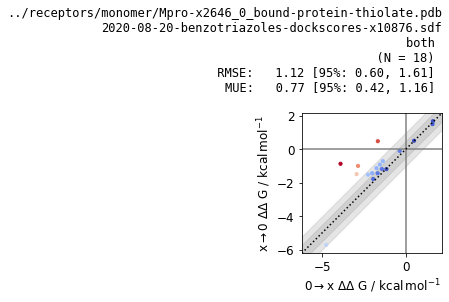

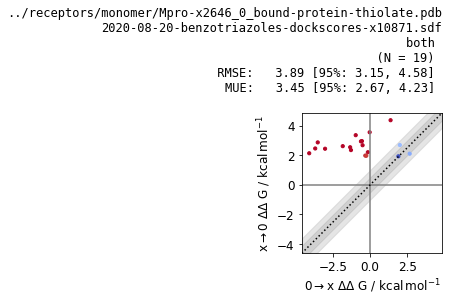

In [13]:
to_delete = []
store_edges = {}

# make combined graphs that have "both" directions (forwards and backwards)
comb_graphs = [t for t in graphs if 'both' in t]

for t in comb_graphs:
    # set old_graph to be the graph in the previously formed graphs object
    old_graph = graphs[t]
    
    # create a new graph labelled "comb" (i.e. combined) and corresponding dict to keep track
    graphs[(t[0],t[1],'comb')] = nx.DiGraph()
    r[(t[0],t[1],'comb')] = {}
    new_graph = graphs[(t[0],t[1],'comb')]
    x = []
    y = []
    xerr = []
    yerr = []
    
    # now, go through every edge (transformation) in the "old" graph
    for edge in old_graph.edges(data=True):
        
        # if we are starting at the ligand 0 (i.e. the one all others are relative to)
        if edge[0] == 0:
            #print(edge)
            
            # if the edge exists between two ligands, get the relevant values
            if old_graph.has_edge(edge[1],edge[0]): # if we have X -> Y transformation
                
                x.append(edge[2]['calc_DDG']) # get X -> Y transformation
                y.append(-old_graph.get_edge_data(edge[1],edge[0])['calc_DDG']) # get opposite Y -> X transformation
                
                # Get the average (i.e. 0.5 the combined values)
                DDG = 0.5*(edge[2]['calc_DDG']-old_graph.get_edge_data(edge[1],edge[0])['calc_DDG'])
                DDG_low = 0.5*(edge[2]['calc_DDG_low']-old_graph.get_edge_data(edge[1],edge[0])['calc_DDG_low']) # this isn't right 
                DDG_high = 0.5*(edge[2]['calc_DDG_high']-old_graph.get_edge_data(edge[1],edge[0])['calc_DDG_high']), # this isn't right
                
                new_graph.add_edge(edge[0],
                                   edge[1],
                                   calc_DDG=DDG,
                                   calc_DDG_low=DDG_low,
                                   calc_DDG_high=DDG_high,
                                   calc_dDDG=(edge[2]['calc_dDDG']**2+old_graph.get_edge_data(edge[1],edge[0])['calc_dDDG']**2)**0.5,
                                   exp_DDG=0.,exp_dDDG=0.1)
                
                if edge[1] in r[(t[0],t[1], 'comb')]:
                    print(edge[1])
                
                else:
                     
                    #r[(t[0],t[1], 'comb')][edge[1]] = [DDG, DDG_low, DDG_high]
                    r[(t[0],t[1], 'comb')][edge[1]] = [DDG,
                                                       DDG_low,
                                                       DDG_high, 
                                                       edge[2]['calc_DDG'],
                                                       -old_graph.get_edge_data(edge[1],edge[0])['calc_DDG'],
                                                       old_graph.get_edge_data(edge[1],edge[0])['start_title']
                                                      ]
    # plot it
    if len(x) > 0 :
        
        plotting._master_plot(np.asarray(x), np.asarray(y),title=f"{t[0]}\n{t[1]}\n{t[2]}", xlabel=r'0$\rightarrow$x', ylabel=r'x$\rightarrow$0')
    to_delete.append(t)

We now filter out the data points where there is poor overlap between the forward and backward transformations. We define poor overlap as anything > 2.0 kcal per mol.

In [32]:
validkeys = [('../receptors/monomer/Mpro-x2646_0_bound-protein-thiolate.pdb',
  '2020-08-20-benzotriazoles-dockscores-x10876.sdf',
  'comb'), ('../receptors/monomer/Mpro-x2646_0_bound-protein-thiolate.pdb',
  '2020-08-20-benzotriazoles-dockscores-x10871.sdf',
  'comb')]


filter_dict = dict(filter(lambda i:i[0] in validkeys, r.items()))

3
11
10
48
97
100
193
196
199
203
207
332
360
368
519
524


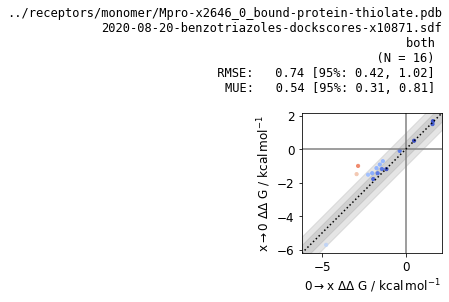

29
520
524


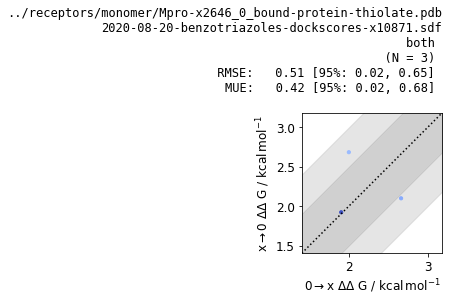

In [41]:
validkeys = [('../receptors/monomer/Mpro-x2646_0_bound-protein-thiolate.pdb',
  '2020-08-20-benzotriazoles-dockscores-x10876.sdf',
  'comb'), ('../receptors/monomer/Mpro-x2646_0_bound-protein-thiolate.pdb',
  '2020-08-20-benzotriazoles-dockscores-x10871.sdf',
  'comb')]

# make a sub dict that contains only the combined entries ('comb').
filter_dict = dict(filter(lambda i:i[0] in validkeys, r.items()))
keys_to_del = {
    ('../receptors/monomer/Mpro-x2646_0_bound-protein-thiolate.pdb',
     '2020-08-20-benzotriazoles-dockscores-x10876.sdf',
     'comb'): [],
    ('../receptors/monomer/Mpro-x2646_0_bound-protein-thiolate.pdb',
     '2020-08-20-benzotriazoles-dockscores-x10871.sdf',
     'comb'): []}

for key in r:
    if key[2] == 'comb':
        for i in r[key]:
            f_b_diff = np.abs(r[key][i][3] - r[key][i][4])
#             print(key, f_b_diff)
            if f_b_diff > 2.0:
                keys_to_del[key].append(i)

# Delete the relevant keys that have been assessed as > 2.0kcal per mol. 
for ligand_key in filter_dict:
    for key in keys_to_del[ligand_key]:
        del filter_dict[ligand_key][key]

# Regenerate the plots for each reference set and see where the changes are
for key in filter_dict:
    x,y = [], []
    for i in filter_dict[key]:
        print(i)
        x.append(filter_dict[key][i][3])
        y.append(filter_dict[key][i][4])
        
    plotting._master_plot(np.asarray(x),
                          np.asarray(y),
                          title=f"{t[0]}\n{t[1]}\n{t[2]}",
                          xlabel=r'0$\rightarrow$x',
                          ylabel=r'x$\rightarrow$0')
    

In [247]:
for run in backwards_data['runs']:
    if run['details']['start_title'] in store[list(store.keys())[0]]['x']:
        print(run['details']['start_title'],
              run['details']['end_title'],
              run['details']['start_pIC50'],
              pIC50_to_dG(float(run['details']['start_pIC50'])))

BENZO_3_1 ALP-POS-d2866bdf-1 5.74624419353312 -13.240547548161839
BENZO_8_1 ALP-POS-d2866bdf-1 5.74624419353312 -13.240547548161839
BENZO_13_1 ALP-POS-d2866bdf-1 5.74624419353312 -13.240547548161839
BENZO_46_1 ALP-POS-d2866bdf-1 5.74624419353312 -13.240547548161839
BENZO_94_1 ALP-POS-d2866bdf-1 5.74624419353312 -13.240547548161839
BENZO_98_1 ALP-POS-d2866bdf-1 5.74624419353312 -13.240547548161839
BENZO_179_1 ALP-POS-d2866bdf-1 5.74624419353312 -13.240547548161839
BENZO_180_2 ALP-POS-d2866bdf-1 5.74624419353312 -13.240547548161839
BENZO_183_1 ALP-POS-d2866bdf-1 5.74624419353312 -13.240547548161839
BENZO_187_1 ALP-POS-d2866bdf-1 5.74624419353312 -13.240547548161839
BENZO_184_1 ALP-POS-d2866bdf-1 5.74624419353312 -13.240547548161839
BENZO_248_2 ALP-POS-d2866bdf-1 5.74624419353312 -13.240547548161839
BENZO_264_2 ALP-POS-d2866bdf-1 5.74624419353312 -13.240547548161839
BENZO_266_1 ALP-POS-d2866bdf-1 5.74624419353312 -13.240547548161839
BENZO_350_1 ALP-POS-d2866bdf-1 5.74624419353312 -13.2405

In [44]:
for run in backwards_data['runs']:
    if run['details']['start_title'] in store[list(store.keys())[0]]['x']:
        print(run['details'])

{'JOBID': 2, 'directory': 'RUN2', 'end': 0, 'end_smiles': 'CN(C)c1ccc(cc1)N(Cc2ccsc2)C(=O)Cn3c4ccccc4nn3', 'end_title': 'ALP-POS-d2866bdf-1', 'ff': 'openff-1.2.0', 'ligand': '2020-08-20-benzotriazoles-dockscores-x10876.sdf', 'protein': '../receptors/monomer/Mpro-x2646_0_bound-protein-thiolate.pdb', 'start': 3, 'start_smiles': 'Cn1cc(cn1)CN(c2ccc(cc2)N(C)C)C(=O)Nn3c4ccccc4nn3', 'start_title': 'BENZO_3_1', 'target': 'SARS-CoV-2 Mpro', 'end_pIC50': None, 'start_pIC50': '5.74624419353312'}
{'JOBID': 9, 'directory': 'RUN9', 'end': 0, 'end_smiles': 'CN(C)c1ccc(cc1)N(Cc2ccsc2)C(=O)Cn3c4ccccc4nn3', 'end_title': 'ALP-POS-d2866bdf-1', 'ff': 'openff-1.2.0', 'ligand': '2020-08-20-benzotriazoles-dockscores-x10876.sdf', 'protein': '../receptors/monomer/Mpro-x2646_0_bound-protein-thiolate.pdb', 'start': 10, 'start_smiles': 'c1ccc2c(c1)nnn2NC(=O)N(Cc3ccsc3)c4ccc(cc4)N5CCCCC5', 'start_title': 'BENZO_8_1', 'target': 'SARS-CoV-2 Mpro', 'end_pIC50': None, 'start_pIC50': '5.74624419353312'}
{'JOBID': 10, '

In [ ]:
# TODO: compare pIC50 values

In [244]:
import logging
from math import log, sqrt

def pIC50_to_dG(pIC50: float, s_conc: float = 375e-9, Km: float = 40e-6) -> float:
    """
    Converts IC50 (in M units) to DG
    Parameters
    ----------
    pIC50 : float
        pIC50
    s_conc : float, default=375E-9
        Substrate concentration in M
    Km : float, default=40E-6
        Substrate concentration for half-maximal enzyme activity
    Returns
    -------
    type
        Description of returned object.
    """
    ic50 = 10 ** -pIC50

    if ic50 > 1e-5:
        logging.warning("Expecting IC50 in M units. Please check.")

    Ki = ic50 / (1 + s_conc / Km)
    return log(Ki)

* ALP-POS-d2866bdf-1 pIC50 = 5.74624419353312
* ALP-POS-c59291d4-2 = 5.78844242195303

In [245]:
pIC50_to_dG(5.74624419353312)

-13.240547548161839

## BAR Overlap

Here, we want to assess whether BAR overlap correlates with various metrics:

* Heavy atom change
* No. of rotatable bonds
* No. of unique atoms changed in the alchemical transformation

We will focus on the "backwards" tranformations for now.

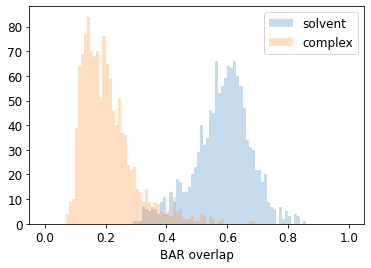

In [31]:
bins = np.linspace(0.,1.,101)
bar_overlaps = [k['analysis']['solvent_phase']['free_energy']['bar_overlap'] for k in backwards_data['runs']]
plt.hist(bar_overlaps,label='solvent',bins=bins,alpha=0.25)
bar_overlaps = [k['analysis']['complex_phase']['free_energy']['bar_overlap'] for k in backwards_data['runs']]
plt.hist(bar_overlaps,label='complex',bins=bins,alpha=0.25)
plt.legend()
plt.xlabel('BAR overlap')
plt.show()

In [127]:
# From PR: https://github.com/choderalab/fah-xchem/pull/47
def plot_bar_distributions(results, title='', filename='BARoverlap'):
    """Plots solvent BAR overlap against complex BAR overlap with marginal distribution
    >>> results = json.load(open('analysis.json','r'))
    >>> plot_bar_distributions(results, 'Sprint 3')
    
    Parameters
    ----------
    results : list(dict)
        Contents of analysis.json
    title : str, default=''
        Title for plot
    filename : str, default='BARoverlap'
        Location to save file
    """
    import numpy as np
    import seaborn as sns
    sns.set(style="ticks")

    x = [r['analysis']['solvent_phase']['free_energy']['bar_overlap'] for r in results]
    y = [r['analysis']['complex_phase']['free_energy']['bar_overlap'] for r in results]

    # BAR overlap has range of 0. to 1. so set limits to represent this
    sns.jointplot(x, y,kind='scatter', color="#4CB391",xlim=(0.,1.),ylim=(0.,1.)).set_axis_labels(f"Solvent BAR overlap\n{title}", "Complex BAR overlap")
#    _produce_plot(filename)

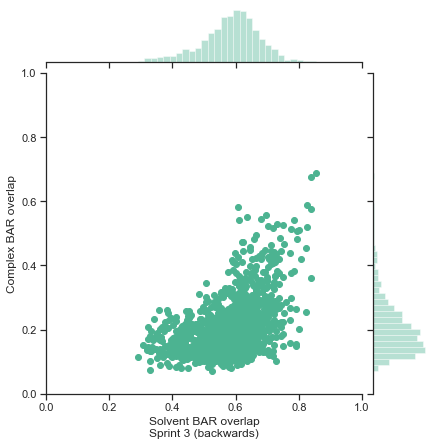

In [128]:
plot_bar_distributions(backwards_data['runs'], 'Sprint 3 (backwards)')

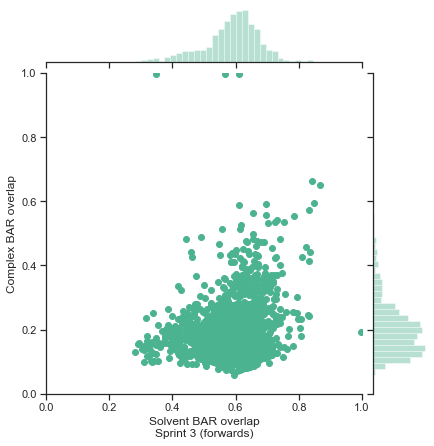

In [129]:
plot_bar_distributions(forwards_data['runs'], 'Sprint 3 (forwards)')

From the above plots there is low BAR overlap in the `complex` phase. We need to investigate why this might be the case:

### BAR Overlap vs. Heavy atom change

In [146]:
start_end = {}

for run in backwards_data['runs']:
    jobid = run['details']['JOBID']
    start_mol = run['details']['start_title']
    end_mol = run['details']['end_title']
    start_smiles = run['details']['start_smiles']
    end_smiles = run['details']['end_smiles']
    bar_overlap = run['analysis']['solvent_phase']['free_energy']['bar_overlap']
    
    # create a custom dictionary for BAR overlap analysis
    start_end[(start_mol, end_mol)] = {"smiles":(start_smiles, end_smiles),
                                       "BAR_overlap": bar_overlap,
                                       "delta_ha": None,  # change in heavy atoms
                                       "N_rbonds": None,  # No. of rotatable bonds
                                       "delta_u_atoms": None  # change in unique atoms
                                      }
for pair in start_end:
    
    # Get the pair of smiles strings for a particular transform (i.e. run)
    smiles = start_end[pair]['smiles']
    
    ha_counts = []
    
    # Calculate the heavy atom change between ligands
    for smiles_string in smiles:
        ims = oechem.oemolistream()
        ims.SetFormat(oechem.OEFormat_SMI)
        ims.openstring(smiles_string)
        
        mols = []
        mol = oechem.OEMol()
        for mol in ims.GetOEMols():
            mols.append(oechem.OEMol(mol))
        
        count = oechem.OECount(mols[0], oechem.OEIsHeavy())
        
        ha_counts.append(count)
        
    start_end[pair]['delta_ha'] = (np.abs(ha_counts[0] - ha_counts[1]))

('BENZO_9_1', 'ALP-POS-d2866bdf-1')
('BENZO_3_1', 'ALP-POS-d2866bdf-1')
('BENZO_4_1', 'ALP-POS-d2866bdf-1')
('BENZO_7_1', 'ALP-POS-d2866bdf-1')
('BENZO_2_1', 'ALP-POS-d2866bdf-1')
('BENZO_6_1', 'ALP-POS-d2866bdf-1')
('BENZO_0_1', 'ALP-POS-d2866bdf-1')
('BENZO_12_1', 'ALP-POS-d2866bdf-1')
('BENZO_1_1', 'ALP-POS-d2866bdf-1')
('BENZO_14_1', 'ALP-POS-d2866bdf-1')
('BENZO_5_1', 'ALP-POS-d2866bdf-1')
('BENZO_8_1', 'ALP-POS-d2866bdf-1')
('BENZO_13_1', 'ALP-POS-d2866bdf-1')
('BENZO_15_1', 'ALP-POS-d2866bdf-1')
('BENZO_11_1', 'ALP-POS-d2866bdf-1')
('BENZO_10_1', 'ALP-POS-d2866bdf-1')
('BENZO_21_1', 'ALP-POS-d2866bdf-1')
('BENZO_16_1', 'ALP-POS-d2866bdf-1')
('BENZO_28_1', 'ALP-POS-d2866bdf-1')
('BENZO_23_1', 'ALP-POS-d2866bdf-1')
('BENZO_18_1', 'ALP-POS-d2866bdf-1')
('BENZO_29_1', 'ALP-POS-d2866bdf-1')
('BENZO_19_1', 'ALP-POS-d2866bdf-1')
('BENZO_31_1', 'ALP-POS-d2866bdf-1')
('BENZO_30_1', 'ALP-POS-d2866bdf-1')
('BENZO_20_1', 'ALP-POS-d2866bdf-1')
('BENZO_22_1', 'ALP-POS-d2866bdf-1')
('BENZO_32_

('BENZO_307_2', 'ALP-POS-d2866bdf-1')
('BENZO_308_2', 'ALP-POS-d2866bdf-1')
('BENZO_309_2', 'ALP-POS-d2866bdf-1')
('BENZO_308_1', 'ALP-POS-d2866bdf-1')
('BENZO_306_2', 'ALP-POS-d2866bdf-1')
('BENZO_310_1', 'ALP-POS-d2866bdf-1')
('BENZO_307_1', 'ALP-POS-d2866bdf-1')
('BENZO_311_1', 'ALP-POS-d2866bdf-1')
('BENZO_311_2', 'ALP-POS-d2866bdf-1')
('BENZO_310_2', 'ALP-POS-d2866bdf-1')
('BENZO_313_2', 'ALP-POS-d2866bdf-1')
('BENZO_312_2', 'ALP-POS-d2866bdf-1')
('BENZO_317_1', 'ALP-POS-d2866bdf-1')
('BENZO_312_1', 'ALP-POS-d2866bdf-1')
('BENZO_314_2', 'ALP-POS-d2866bdf-1')
('BENZO_315_2', 'ALP-POS-d2866bdf-1')
('BENZO_314_1', 'ALP-POS-d2866bdf-1')
('BENZO_315_1', 'ALP-POS-d2866bdf-1')
('BENZO_317_2', 'ALP-POS-d2866bdf-1')
('BENZO_321_1', 'ALP-POS-d2866bdf-1')
('BENZO_321_2', 'ALP-POS-d2866bdf-1')
('BENZO_316_2', 'ALP-POS-d2866bdf-1')
('BENZO_319_2', 'ALP-POS-d2866bdf-1')
('BENZO_318_1', 'ALP-POS-d2866bdf-1')
('BENZO_319_1', 'ALP-POS-d2866bdf-1')
('BENZO_323_1', 'ALP-POS-d2866bdf-1')
('BENZO_320_

('BENZO_101_1', 'ALP-POS-c59291d4-2')
('BENZO_94_1', 'ALP-POS-c59291d4-2')
('BENZO_102_1', 'ALP-POS-c59291d4-2')
('BENZO_105_1', 'ALP-POS-c59291d4-2')
('BENZO_100_1', 'ALP-POS-c59291d4-2')
('BENZO_103_1', 'ALP-POS-c59291d4-2')
('BENZO_107_1', 'ALP-POS-c59291d4-2')
('BENZO_98_1', 'ALP-POS-c59291d4-2')
('BENZO_110_1', 'ALP-POS-c59291d4-2')
('BENZO_108_1', 'ALP-POS-c59291d4-2')
('BENZO_104_1', 'ALP-POS-c59291d4-2')
('BENZO_112_1', 'ALP-POS-c59291d4-2')
('BENZO_113_1', 'ALP-POS-c59291d4-2')
('BENZO_106_1', 'ALP-POS-c59291d4-2')
('BENZO_109_1', 'ALP-POS-c59291d4-2')
('BENZO_111_1', 'ALP-POS-c59291d4-2')
('BENZO_115_1', 'ALP-POS-c59291d4-2')
('BENZO_117_1', 'ALP-POS-c59291d4-2')
('BENZO_114_1', 'ALP-POS-c59291d4-2')
('BENZO_121_1', 'ALP-POS-c59291d4-2')
('BENZO_116_1', 'ALP-POS-c59291d4-2')
('BENZO_120_1', 'ALP-POS-c59291d4-2')
('BENZO_119_1', 'ALP-POS-c59291d4-2')
('BENZO_125_1', 'ALP-POS-c59291d4-2')
('BENZO_118_1', 'ALP-POS-c59291d4-2')
('BENZO_124_1', 'ALP-POS-c59291d4-2')
('BENZO_123_1'

('BENZO_324_2', 'ALP-POS-c59291d4-2')
('BENZO_329_2', 'ALP-POS-c59291d4-2')
('BENZO_326_2', 'ALP-POS-c59291d4-2')
('BENZO_329_1', 'ALP-POS-c59291d4-2')
('BENZO_327_2', 'ALP-POS-c59291d4-2')
('BENZO_328_2', 'ALP-POS-c59291d4-2')
('BENZO_330_2', 'ALP-POS-c59291d4-2')
('BENZO_331_2', 'ALP-POS-c59291d4-2')
('BENZO_332_2', 'ALP-POS-c59291d4-2')
('BENZO_328_1', 'ALP-POS-c59291d4-2')
('BENZO_333_1', 'ALP-POS-c59291d4-2')
('BENZO_331_1', 'ALP-POS-c59291d4-2')
('BENZO_330_1', 'ALP-POS-c59291d4-2')
('BENZO_333_2', 'ALP-POS-c59291d4-2')
('BENZO_332_1', 'ALP-POS-c59291d4-2')
('BENZO_337_1', 'ALP-POS-c59291d4-2')
('BENZO_336_1', 'ALP-POS-c59291d4-2')
('BENZO_335_1', 'ALP-POS-c59291d4-2')
('BENZO_338_1', 'ALP-POS-c59291d4-2')
('BENZO_334_1', 'ALP-POS-c59291d4-2')
('BENZO_334_2', 'ALP-POS-c59291d4-2')
('BENZO_343_1', 'ALP-POS-c59291d4-2')
('BENZO_347_1', 'ALP-POS-c59291d4-2')
('BENZO_335_2', 'ALP-POS-c59291d4-2')
('BENZO_345_1', 'ALP-POS-c59291d4-2')
('BENZO_340_1', 'ALP-POS-c59291d4-2')
('BENZO_344_

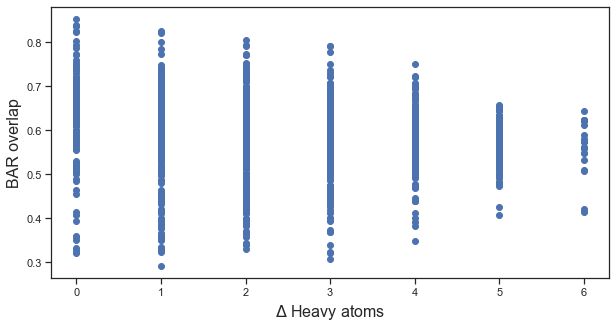

In [141]:
fig, ax = plt.subplots(figsize=(10,5))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

delta_ha = []
bar_overlap = []

for i, ligand in enumerate(start_end):
    
    delta_ha.append(start_end[ligand]['delta_ha'])
    bar_overlap.append(start_end[ligand]['BAR_overlap'])
    
plt.scatter(delta_ha, bar_overlap)
plt.xlabel(r'$\Delta$ Heavy atoms', size=16)
plt.ylabel('BAR overlap', size=16)
plt.show()

Looking at the top 20 ligands from https://fah-ws3.s3.amazonaws.com/covid-moonshot/sprints/sprint-3/2020-08-20-benzotriazoles-backwards/index.html

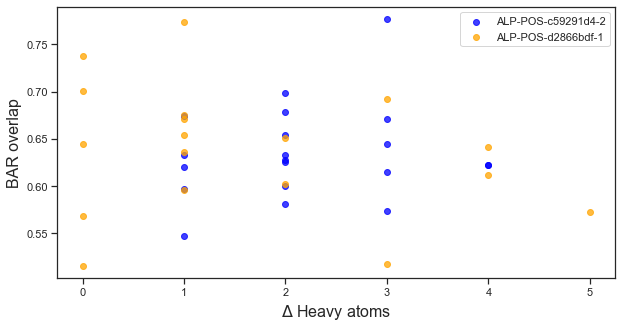

In [155]:
fig, ax = plt.subplots(figsize=(10,5))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

delta_ha = []
bar_overlap = []

for i, ligand in enumerate(start_end):

    if ligand[0] in top_ligands and ligand[1] == "ALP-POS-c59291d4-2":
    
        delta_ha.append(start_end[ligand]['delta_ha'])
        bar_overlap.append(start_end[ligand]['BAR_overlap'])
    
    else:
        continue
    
plt.scatter(delta_ha, bar_overlap, c="blue", alpha=0.75)

delta_ha = []
bar_overlap = []

for i, ligand in enumerate(start_end):

    if ligand[0] in top_ligands and ligand[1] == "ALP-POS-d2866bdf-1":
    
        delta_ha.append(start_end[ligand]['delta_ha'])
        bar_overlap.append(start_end[ligand]['BAR_overlap'])
    
    else:
        continue
    
plt.scatter(delta_ha, bar_overlap, c="orange", alpha=0.75)



plt.xlabel(r'$\Delta$ Heavy atoms', size=16)
plt.ylabel('BAR overlap', size=16)
plt.legend(("ALP-POS-c59291d4-2", "ALP-POS-d2866bdf-1"), loc="best")
plt.show()

From the above scatter plots it looks like there is little correlation between the change in heavy atoms and BAR overlap.

### BAR Overlap vs. No. rotatable bonds

In [175]:
def CountRotors(ifs):
    rotcounts = []
    for mol in ifs.GetOEMols():
        oechem.OEFindRingAtomsAndBonds(mol)
        # ideally we want to use oechem.OEGetRotatableBondCount(), but this doesn't seemed to be implemented properly.
        nrots = oechem.OECount(mol, oechem.OEIsRotor())

#         while nrots >= len(rotcounts):
#             rotcounts.append(0)
#         rotcounts[nrots] += 1

#     print("Max rotors:", len(rotcounts) - 1)
#     print("Rotorcount distribution:")

#     for rots, numrot in enumerate(rotcounts):
#         print("\t%d:\t%d" % (rots, numrot))

    return nrots

In [176]:
for pair in start_end:
    
    ims = oechem.oemolistream()
    ims.SetFormat(oechem.OEFormat_SMI)
    
    # calculate No. rot bonds in the BENZO ligand
    if not ims.openstring(start_end[pair]['smiles'][0]):
        oechem.OEThrow.Fatal("Unable to open %s for reading" % start_end[pair]['smiles'][0])
        
    n_rotatable_bonds = CountRotors(ims)
    
    start_end[pair]["N_rbonds"] = n_rotatable_bonds

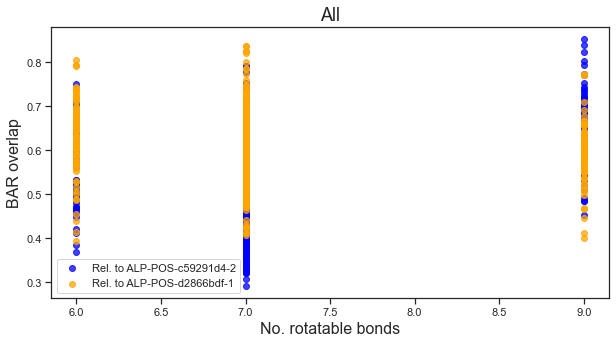

In [171]:
fig, ax = plt.subplots(figsize=(10,5))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

n_rot_bonds = []
bar_overlap = []

for i, ligand in enumerate(start_end):

    if ligand[1] == "ALP-POS-c59291d4-2":
    
        n_rot_bonds.append(start_end[ligand]['N_rbonds'])
        bar_overlap.append(start_end[ligand]['BAR_overlap'])
    
    else:
        continue
    
plt.scatter(n_rot_bonds, bar_overlap, c="blue", alpha=0.75)

n_rot_bonds = []
bar_overlap = []

for i, ligand in enumerate(start_end):

    if ligand[1] == "ALP-POS-d2866bdf-1":
    
        n_rot_bonds.append(start_end[ligand]['N_rbonds'])
        bar_overlap.append(start_end[ligand]['BAR_overlap'])
    
    else:
        continue
    
plt.scatter(n_rot_bonds, bar_overlap, c="orange", alpha=0.75)
    
plt.xlabel(r'No. rotatable bonds', size=16)
plt.ylabel('BAR overlap', size=16)
plt.legend(("Rel. to ALP-POS-c59291d4-2", "Rel. to ALP-POS-d2866bdf-1"), loc="best")
plt.title("All", size=18)
plt.show()

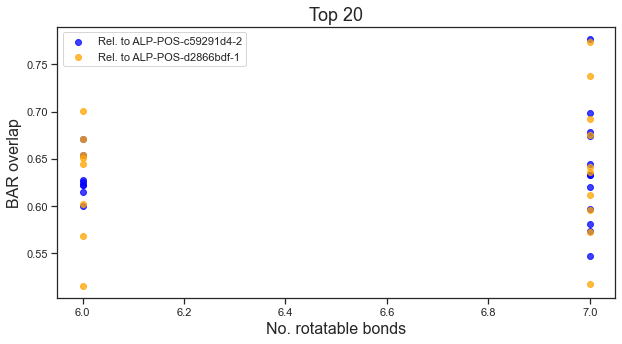

In [172]:
fig, ax = plt.subplots(figsize=(10,5))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

n_rot_bonds = []
bar_overlap = []

for i, ligand in enumerate(start_end):

    if ligand[0] in top_ligands and ligand[1] == "ALP-POS-c59291d4-2":
    
        n_rot_bonds.append(start_end[ligand]['N_rbonds'])
        bar_overlap.append(start_end[ligand]['BAR_overlap'])
    
    else:
        continue
    
plt.scatter(n_rot_bonds, bar_overlap, c="blue", alpha=0.75)

n_rot_bonds = []
bar_overlap = []

for i, ligand in enumerate(start_end):

    if ligand[0] in top_ligands and ligand[1] == "ALP-POS-d2866bdf-1":
    
        n_rot_bonds.append(start_end[ligand]['N_rbonds'])
        bar_overlap.append(start_end[ligand]['BAR_overlap'])
    
    else:
        continue
    
plt.scatter(n_rot_bonds, bar_overlap, c="orange", alpha=0.75)

plt.xlabel(r'No. rotatable bonds', size=16)
plt.ylabel('BAR overlap', size=16)
plt.legend(("Rel. to ALP-POS-c59291d4-2", "Rel. to ALP-POS-d2866bdf-1"), loc="best")
plt.title("Top 20", size=18)
plt.show()

### BAR Overlap vs. Unique atom changes

In [182]:
def get_unique(pair):

    ref = oechem.OEGraphMol() 
    target = oechem.OEGraphMol() 

    oechem.OESmilesToMol(ref, start_end[pair]['smiles'][1])  # ALP-POS-d2866bdf-1 or ALP-POS-c59291d4-2 reference
    oechem.OESmilesToMol(target, start_end[pair]['smiles'][0])  # The BENZO ligand

    atomexpr = oechem.OEExprOpts_DefaultAtoms
    bondexpr = oechem.OEExprOpts_DefaultBonds

    refQ = oechem.OEQMol(ref)
    # generate query with atom and bond expression options
    refQ.BuildExpressions(atomexpr, bondexpr)
    mcss = oechem.OEMCSSearch(refQ)

    unique = True
    count = 1
    # loop over matches
    for match in mcss.Match(target, unique):
        match_num = match.NumAtoms()

    return match_num

In [183]:
# N.B. this could be wrong...
for pair in start_end:
    
    # Get the No. atoms for the reference, either ALP-POS-d2866bdf-1 or ALP-POS-c59291d4-2
    ims_ref = oechem.oemolistream()
    ims_ref.SetFormat(oechem.OEFormat_SMI)
    
    if not ims_ref.openstring(start_end[pair]['smiles'][1]):
        oechem.OEThrow.Fatal("Unable to reference SMILES open for reading")
        
    acache = []
    for mol in ims_ref.GetOEMols():
        for atom in mol.GetAtoms():
            acache.append(atom)

    n_old_atoms = len(acache)
    
    ims = oechem.oemolistream()
    ims.SetFormat(oechem.OEFormat_SMI)
    
    if not ims.openstring(start_end[pair]['smiles'][0]):
        oechem.OEThrow.Fatal("Unable to open target SMILES for reading")

    n_u_atoms = get_unique(pair)
    
    #delta_u_atoms = n_old_atoms + np.abs(n_old_atoms - n_u_atoms)
    
    delta_u_atoms = np.abs(n_old_atoms - n_u_atoms)
    
    start_end[pair]["delta_u_atoms"] = delta_u_atoms

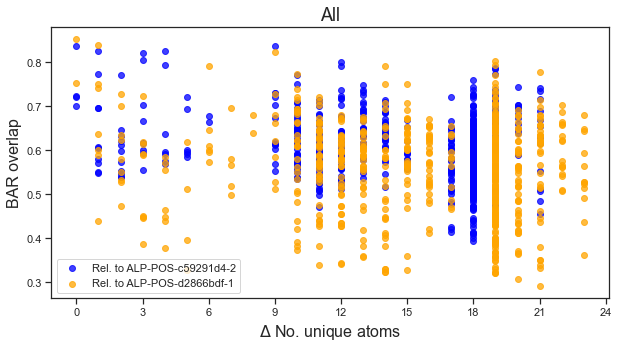

In [194]:
fig, ax = plt.subplots(figsize=(10,5))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

delta_n_u_atoms = []
bar_overlap = []

for i, ligand in enumerate(start_end):
    
    if ligand[1] == "ALP-POS-d2866bdf-1":
    
        delta_n_u_atoms.append(start_end[ligand]['delta_u_atoms'])
        bar_overlap.append(start_end[ligand]['BAR_overlap'])
    
plt.scatter(delta_n_u_atoms, bar_overlap, c="blue", alpha=0.75)

delta_n_u_atoms = []
bar_overlap = []

for i, ligand in enumerate(start_end):
    
    if ligand[1] == "ALP-POS-c59291d4-2":
    
        delta_n_u_atoms.append(start_end[ligand]['delta_u_atoms'])
        bar_overlap.append(start_end[ligand]['BAR_overlap'])
    
plt.scatter(delta_n_u_atoms, bar_overlap, c="orange", alpha=0.75)

plt.xlabel(r'$\Delta$ No. unique atoms', size=16)
plt.ylabel('BAR overlap', size=16)
plt.legend(("Rel. to ALP-POS-c59291d4-2", "Rel. to ALP-POS-d2866bdf-1"), loc="best")
plt.title("All", size=18)

plt.show()

Text(0.5, 1.0, 'Top 20')

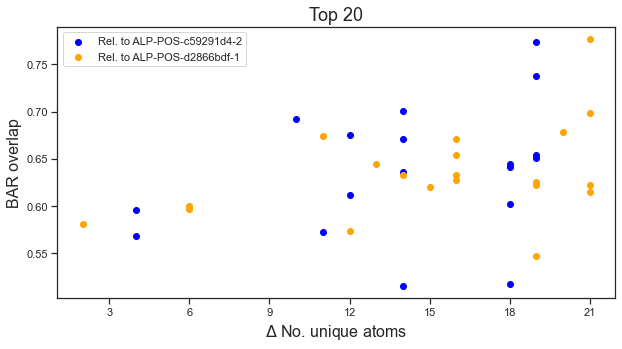

In [195]:
fig, ax = plt.subplots(figsize=(10,5))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

delta_n_u_atoms = []
bar_overlap = []

for i, ligand in enumerate(start_end):
    
    if ligand[0] in top_ligands and ligand[1] == "ALP-POS-d2866bdf-1":
        delta_n_u_atoms.append(start_end[ligand]['delta_u_atoms'])
        bar_overlap.append(start_end[ligand]['BAR_overlap'])
    
plt.scatter(delta_n_u_atoms, bar_overlap, c="blue")

delta_n_u_atoms = []
bar_overlap = []

for i, ligand in enumerate(start_end):
    
    if ligand[0] in top_ligands and ligand[1] == "ALP-POS-c59291d4-2":
        delta_n_u_atoms.append(start_end[ligand]['delta_u_atoms'])
        bar_overlap.append(start_end[ligand]['BAR_overlap'])
    
plt.scatter(delta_n_u_atoms, bar_overlap, c="orange")

plt.xlabel(r'$\Delta$ No. unique atoms', size=16)
plt.ylabel('BAR overlap', size=16)
plt.legend(("Rel. to ALP-POS-c59291d4-2", "Rel. to ALP-POS-d2866bdf-1"), loc="best")
plt.title("Top 20", size=18)

## Investigating low BAR overlap structures

Here we will investigate the structure of ligands that exhibit low BAR overlap and also are in the top 20 ligands from Sprint 3 in terms of $\Delta$G.

In [206]:
start_end_lowBAR = {x:start_end[x] for x in start_end.keys() if start_end[x]["BAR_overlap"] <= 0.65}
start_end_lowBAR_top20 = {x:start_end_lowBAR[x] for x in start_end_lowBAR.keys() if x[0] in top_ligands}

In [215]:
from openforcefield.topology import Molecule
from openeye import oechem, oegraphsim, oedepict

all_smiles = []

for pair in start_end_lowBAR_top20:
    all_smiles.append(start_end_lowBAR_top20[pair]["smiles"][0])

n_molecules = len(all_smiles)

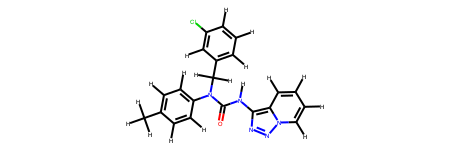

In [223]:
from openforcefield.topology import Molecule

m = Molecule.from_smiles(all_smiles[3])
m.visualize()

Testing things:

In [66]:
from openeye import oedepict
from openeye import oegraphsim

refmol = oechem.OEGraphMol()
oechem.OESmilesToMol(refmol, start_end[pair]['smiles'][0])
oedepict.OEPrepareDepiction(refmol)

fitmol = oechem.OEGraphMol()
oechem.OESmilesToMol(fitmol, start_end[pair]['smiles'][1])
oedepict.OEPrepareDepiction(fitmol)

mcss = oechem.OEMCSSearch(oechem.OEMCSType_Approximate)
atomexpr = oechem.OEExprOpts_DefaultAtoms
bondexpr = oechem.OEExprOpts_DefaultBonds
mcss.Init(refmol, atomexpr, bondexpr)
mcss.SetMCSFunc(oechem.OEMCSMaxBondsCompleteCycles())

alignres = oedepict.OEPrepareAlignedDepiction(fitmol, mcss)

image = oedepict.OEImage(400, 200)

rows, cols = 1, 2
grid = oedepict.OEImageGrid(image, rows, cols)

overlaps = oegraphsim.OEGetFPOverlap(refmol, fitmol,
                                     oegraphsim.OEGetFPType(oegraphsim.OEFPType_Tree))
oedepict.OEPrepareMultiAlignedDepiction(fitmol, refmol, overlaps)

opts = oedepict.OE2DMolDisplayOptions(grid.GetCellWidth(), grid.GetCellHeight(),
                                      oedepict.OEScale_AutoScale)
opts.SetTitleLocation(oedepict.OETitleLocation_Hidden)

refscale = oedepict.OEGetMoleculeScale(refmol, opts)
fitscale = oedepict.OEGetMoleculeScale(fitmol, opts)
opts.SetScale(min(refscale, fitscale))

refdisp = oedepict.OE2DMolDisplay(mcss.GetPattern(), opts)
fitdisp = oedepict.OE2DMolDisplay(fitmol, opts)

if alignres.IsValid():
    refabset = oechem.OEAtomBondSet(alignres.GetPatternAtoms(), alignres.GetPatternBonds())
    oedepict.OEAddHighlighting(refdisp, oechem.OEBlueTint,
                               oedepict.OEHighlightStyle_BallAndStick, refabset)

    fitabset = oechem.OEAtomBondSet(alignres.GetTargetAtoms(), alignres.GetTargetBonds())
    oedepict.OEAddHighlighting(fitdisp, oechem.OEBlueTint,
                               oedepict.OEHighlightStyle_BallAndStick, fitabset)

refcell = grid.GetCell(1, 1)
oedepict.OERenderMolecule(refcell, refdisp)

fitcell = grid.GetCell(1, 2)
oedepict.OERenderMolecule(fitcell, fitdisp)


doubleimage = oedepict.OEImage(image, 2.0)
oedepict.OEWriteImage("Align2.png", image)

True

In [48]:
for k in backwards_data['runs']:
    for x in k:
        print(x)
        print(k[x].keys())
        for y in k[x].keys():
            if isinstance(k[x][y], dict):
                print(k[x][y].keys())
    break

details
dict_keys(['JOBID', 'directory', 'end', 'end_smiles', 'end_title', 'ff', 'ligand', 'protein', 'start', 'start_smiles', 'start_title', 'target', 'end_pIC50', 'start_pIC50'])
analysis
dict_keys(['complex_phase', 'solvent_phase', 'binding'])
dict_keys(['free_energy', 'gens'])
dict_keys(['free_energy', 'gens'])
dict_keys(['delta_f', 'ddelta_f'])
